In [4]:
import os
print("Current working directory:", os.getcwd())


import sys, os
sys.path.append(os.path.abspath("../src"))

from outliers import summarize_outliers


Current working directory: C:\Users\qochi\bootcamp_millicent_qochiwa\project\notebooks


In [5]:
import os
from dotenv import load_dotenv
import pandas as pd

load_dotenv()
PROCESSED = os.getenv("PROCESSED_DATA_CSV")
print("Path from env:", PROCESSED)

df = pd.read_csv(PROCESSED)
print(df.shape, "loaded successfully")


Path from env: ../data/processed/cleaned_loan_data.csv
(17719, 22) loaded successfully


In [7]:
# Excluding identifier-like columns from outlier logic:
exclude = [c for c in df.columns if "id" in c.lower() or "number" in c.lower()]
exclude


['ID number', 'Personnel Number', 'LoanId']

In [8]:
df.describe(include="all").T.head(20)

out_tbl = summarize_outliers(df, k=1.5, exclude=exclude)
out_tbl


,column,lower_bound,upper_bound,n_outliers,pct_outliers
0,Basic Salary,5129.94500,7756.30500,5254,29.651786
9,InterestRate,30.50000,42.50000,1693,9.554715
6,DisbursementAmount,-14961.49250,40988.24750,1105,6.236244
8,PrincipalBalance,-28661.85000,67360.79000,643,3.628873
1,Payment,-1091.42000,9580.26000,640,3.611942
5,LoanAmount,-27192.73500,77857.78500,522,2.945990
2,AFFORDABILITY,-3364.31825,6456.11575,506,2.855692
7,Instalment,-1046.04250,4273.69750,419,2.364693
4,Tenure,-30.00000,114.00000,34,0.191884
3,Age,-4.50000,87.50000,0,0.000000


In [11]:
from outliers import winsorize_iqr, remove_outliers_iqr


df_cap = winsorize_iqr(df, k=1.5, exclude=exclude)
df_trim = remove_outliers_iqr(df, k=1.5, exclude=exclude)

print("rows: orig/cap/trim =", len(df), len(df_cap), len(df_trim))
df_cap.to_csv("../data/processed/cleaned_loan_data_capped.csv", index=False)
df_trim.to_csv("../data/processed/cleaned_loan_data_trimmed.csv", index=False)


rows: orig/cap/trim = 17719 17719 10333


In [13]:
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

def stats(d):
    s = d[num_cols].agg(["count","mean","median","std","min","max"]).T
    s["skew"] = d[num_cols].skew(numeric_only=True)
    return s

before = stats(df).add_prefix("orig_")
after_cap = stats(df_cap).add_prefix("cap_")
after_trim = stats(df_trim).add_prefix("trim_")

compare = before.join(after_cap).join(after_trim)
compare


,orig_count,orig_mean,orig_median,orig_std,orig_min,orig_max,orig_skew,cap_count,cap_mean,cap_median,...,cap_min,cap_max,cap_skew,trim_count,trim_mean,trim_median,trim_std,trim_min,trim_max,trim_skew
Personnel Number,17719.0,230407.285569,242040.000,122276.375727,5.00,438575.000,-0.237588,17719.0,230407.285569,242040.000,...,5.000,438575.00000,-0.237588,10333.0,235437.541276,244412.00,114785.205876,54.000,436611.000,-0.286228
Basic Salary,17718.0,7016.286609,6595.920,2422.001464,2721.27,68018.480,5.094536,17718.0,6504.516945,6595.920,...,5129.945,7756.30500,-0.245002,10332.0,6470.949806,6595.92,495.115374,5175.330,7740.500,-1.158859
Payment,17719.0,4606.339970,3917.560,2512.706212,1353.34,60504.290,3.485381,17719.0,4478.823803,3917.560,...,1353.340,9580.26000,1.028752,10333.0,4108.393722,3558.69,1569.734577,1353.340,9347.060,1.070479
AFFORDABILITY,17718.0,1800.008925,1114.457,1998.376850,-2419.44,33296.898,2.318654,17718.0,1739.543527,1114.457,...,-2419.440,6456.11575,1.093712,10332.0,1520.280452,943.13,1547.246902,-0.002,6455.408,1.085959
Age,17719.0,41.655229,42.000,13.763058,18.00,65.000,-0.006663,17719.0,41.655229,42.000,...,18.000,65.00000,-0.006663,10333.0,41.602536,41.00,13.725485,18.000,65.000,0.010039
Tenure,17719.0,43.831367,60.000,20.856903,1.00,240.000,0.186274,17719.0,43.697782,60.000,...,1.000,114.00000,-0.570742,10333.0,46.929933,60.00,17.226535,2.000,112.000,-0.880342
LoanAmount,17719.0,27891.086749,22302.220,20691.801069,635.56,232228.120,1.439390,17719.0,27455.237824,22302.220,...,635.560,77857.78500,0.948689,10333.0,25083.085794,22302.22,15193.236413,653.030,77857.780,0.801396
DisbursementAmount,17719.0,15773.275878,10729.710,14757.908433,-235.19,120000.000,2.130473,17719.0,14706.238937,10729.710,...,-235.190,40988.24750,0.967348,10333.0,13455.603281,10655.65,9481.567303,-235.190,40947.840,0.876625
Instalment,17719.0,1723.419626,1540.020,1035.126459,188.66,13617.060,1.411301,17719.0,1704.843580,1540.020,...,188.660,4273.69750,0.829298,10333.0,1509.635063,1401.26,778.298889,189.170,4243.390,0.641576
PrincipalBalance,17719.0,22149.644522,16413.570,19743.761655,0.00,218539.460,1.571845,17719.0,21595.193600,16413.570,...,0.000,67360.79000,1.007037,10333.0,20048.652905,16665.96,14674.203900,73.200,67138.020,0.931867


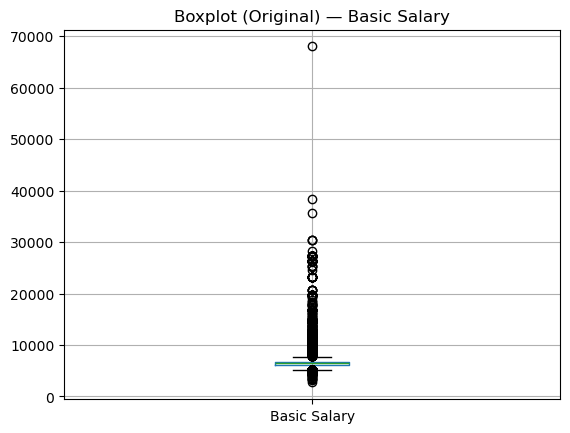

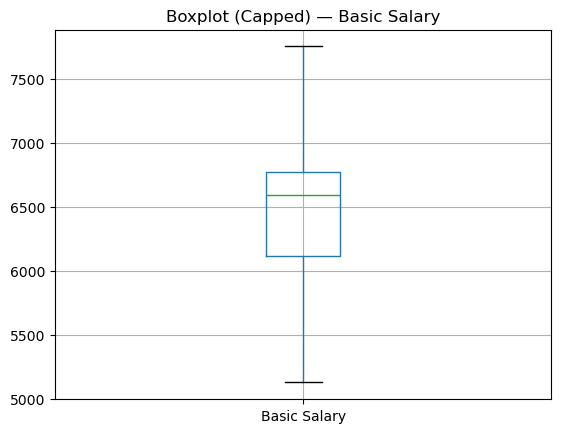

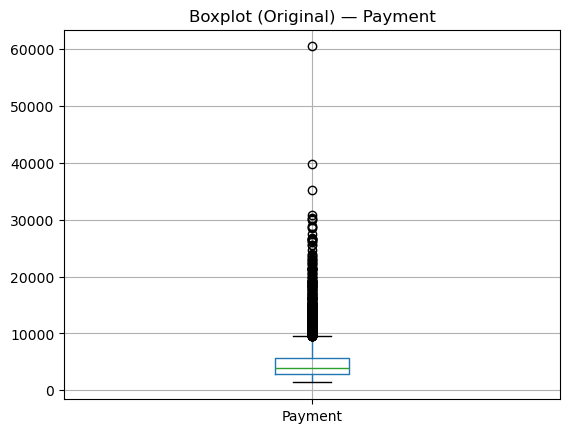

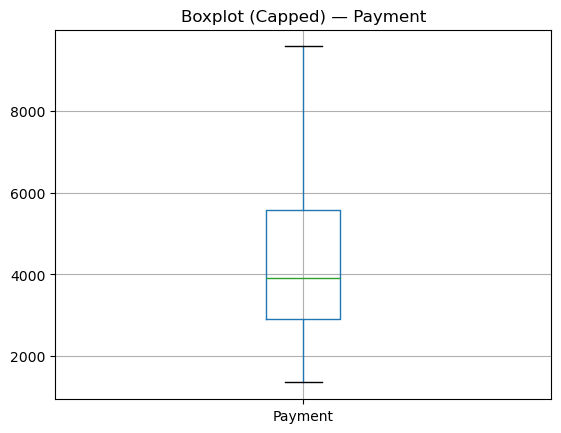

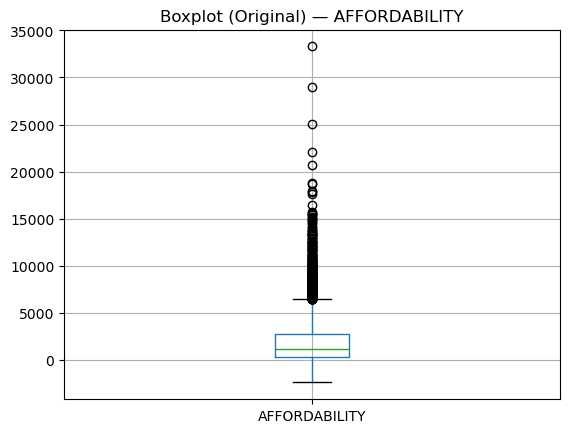

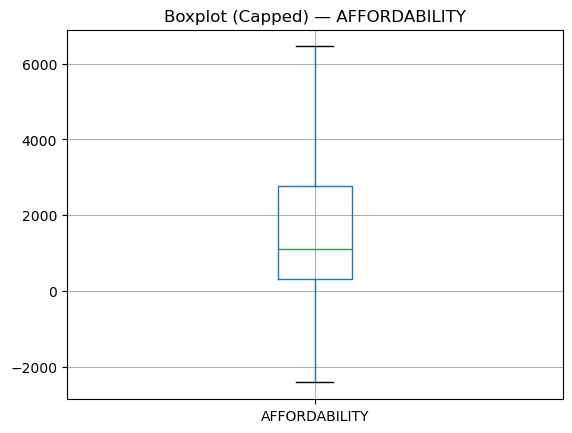

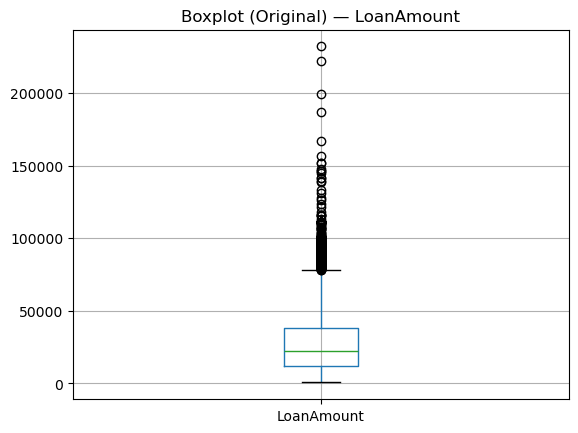

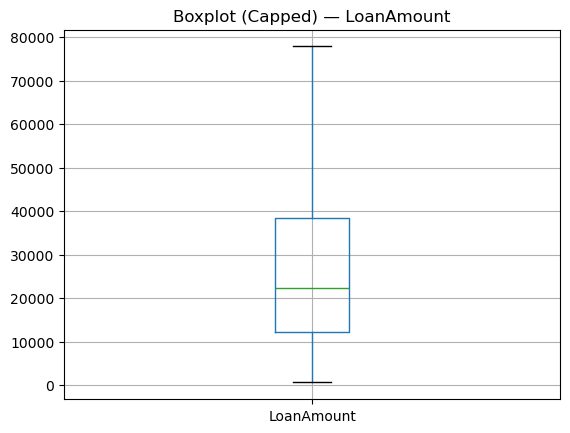

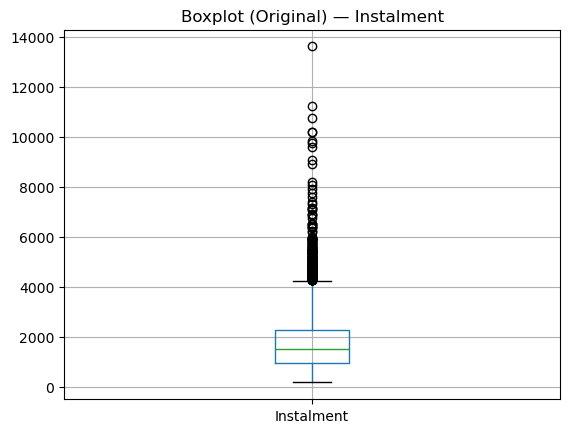

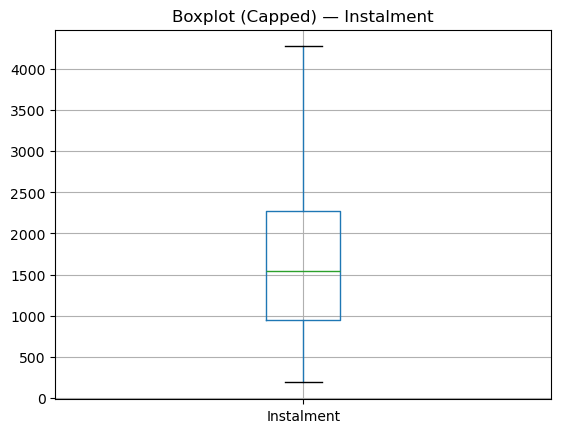

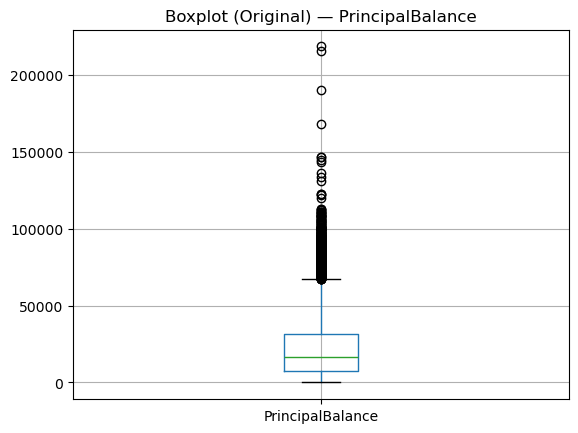

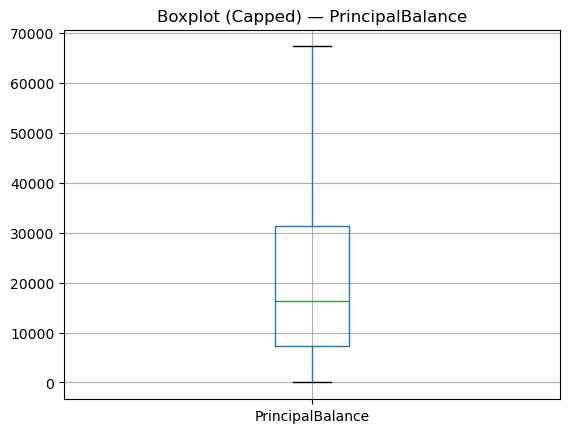

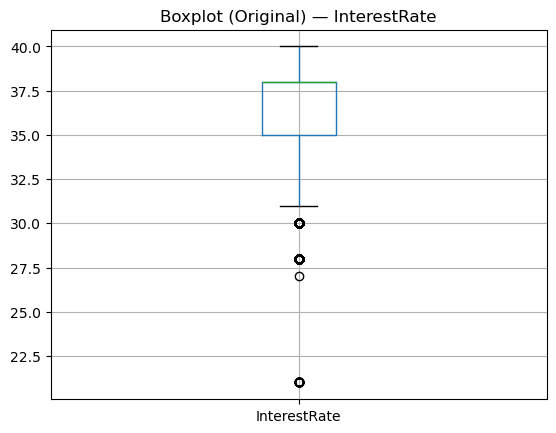

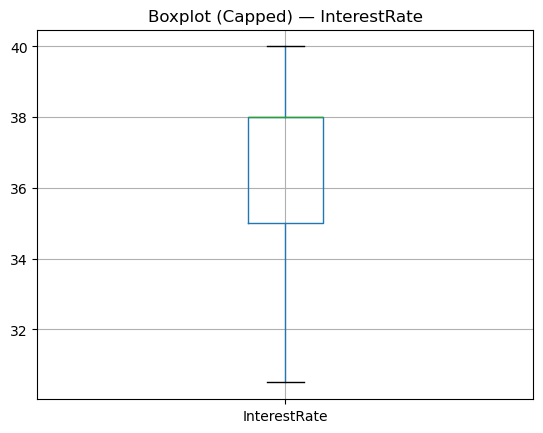

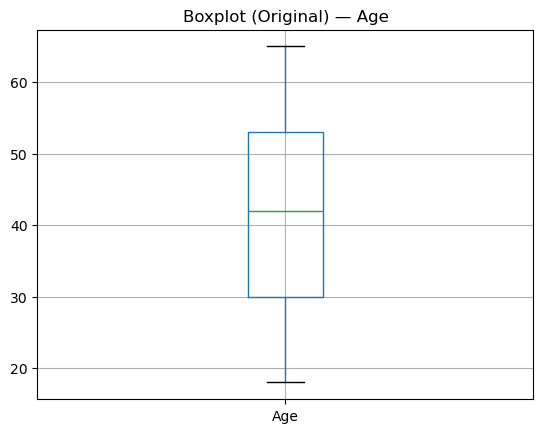

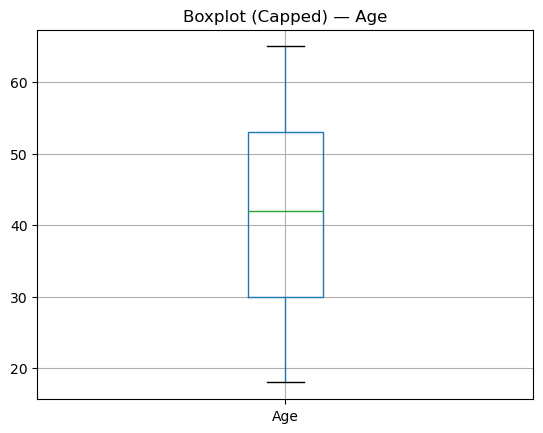

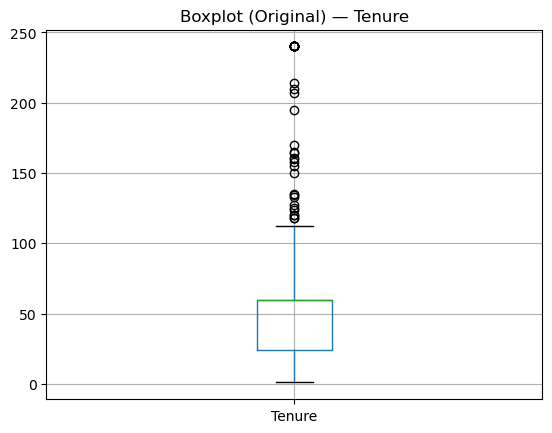

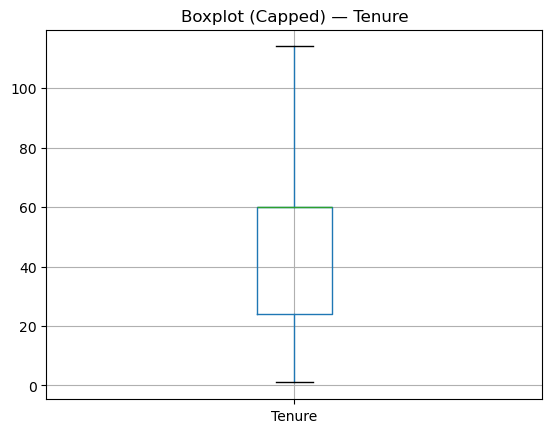

In [14]:
import matplotlib.pyplot as plt

for col in ["Basic Salary","Payment","AFFORDABILITY","LoanAmount","Instalment","PrincipalBalance","InterestRate","Age","Tenure"]:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        plt.figure()
        df[[col]].boxplot()
        plt.title(f"Boxplot (Original) — {col}")
        plt.show()

        plt.figure()
        df_cap[[col]].boxplot()
        plt.title(f"Boxplot (Capped) — {col}")
        plt.show()


In [ ]:
git add src/outliers.py notebooks/sensitivity_outliers.ipynb README.md ^
data/processed/cleaned_loan_data_capped.csv ^
data/processed/cleaned_loan_data_trimmed.csv
git commit -m "Stage 07: Outlier analysis – reusable IQR functions, sensitivity notebook, docs, and processed variants"
git push origin main
